In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import datetime

import sys
from os.path import dirname, abspath
import os
sys.path.append(dirname(dirname(abspath('__file__')))+'/utils')

from sklearn.model_selection import train_test_split

from keras.layers import Dense, LeakyReLU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Activation, BatchNormalization
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras import optimizers
from keras.utils.vis_utils import plot_model
import keras
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

import pickle

from check_performance import checkPerformance
from line_suppression import seg_line_sup

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def NaiveApproach(data_sample):

    out = []
    sign = []
    indices = range(data_sample.shape[0])
    
    # 3 samples, mean    
    for i in range(4,data_sample.shape[0]-4):
        yn = data_sample
        ma = np.mean([yn[i-3], yn[i-2], yn[i-1]]) 
        mb = np.mean([yn[i+1], yn[i+2], yn[i+3]]) 
        thres = np.mean([(ma), (mb)]) + 0.75*18.1
        thres2 = np.mean([(ma), (mb)]) - 0.75*18.1
        o = (yn[i] > thres or  yn[i] < thres2 )
        out.append(o)
        if o and i in indices:
            if yn[i] >= thres:
                s = 1
            else:
                s = -1
            sign.append(s)
    
    results_tmp = np.where(out)[0] + 4
    results_naive = []
    for j in list(results_tmp):
        if j in indices:
            results_naive.append(j)
    
    return (results_naive, sign)

def correct_ts(data_sample):
    new_data_sample = data_sample.copy()
    result_idxs, signs = NaiveApproach(data_sample)
    res = zip(result_idxs, signs)
    for idx, sign in res:
        new_data_sample[idx] += -1 * sign * 18.1 
    return new_data_sample

In [4]:
## Input the filenames and parameters:
filename = 'segmented_ts_sim_with_UE_02.pkl'
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
interpolation_method = 'original'

In [5]:
## Create variables with directories to external files:
directory = os.path.join(dirname(os.getcwd()), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)

In [6]:
## Import the measurements:
data_imported = pd.read_pickle(file_data)
data_df = data_imported['time-series with UE']

## Correct the unwrapping errors
# data_df_corrected = data_df.map(correct_ts)
with open("data_df_corrected.pkl", "rb") as file:
    data_df_corrected = pickle.load(file)

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
full_x = np.load(file_full_indices) 
indices = [int(i*365.25/11) for i in orig_x]

## Reverse indices using the last existing index
indices_reverse = []
for i in range(297):
    if i in indices:
        indices_reverse.append(i)
    else:
        indices_reverse.append(indices_reverse[i-1])

## Load the answers (ground truth):
points = pd.DataFrame(data_imported['list of UE'], index = data_imported.index)
points.columns = ['points']
segm_lines = pd.DataFrame(data_imported['segm_lines'], index = data_imported.index)
segm_lines.columns = ['segm_lines']

In [7]:
record_num = len(data_df_corrected)
record_length = len(data_df_corrected.iloc[0])

## Reshape the data from DataFrame into an array
data = np.zeros((record_num, record_length))
for idx, ar in enumerate(data_df_corrected.values):
    data[idx, :] = ar

In [8]:
ans_pt = np.zeros((record_num, record_length))
for idx, l in enumerate(points.values):
    for p in l[0]:
        ans_pt[idx, p] = 1

In [9]:
ans_seg = np.zeros((record_num, record_length))
for idx, l in enumerate(segm_lines.values):
    for s in l[0]:
        ans_seg[idx, s] = 1

In [10]:
test_ratio = 0.1
val_ratio = 0.2
# val_ratio_adj = (val_ratio / (1 - test_ratio))
val_ratio_adj = 0.22222222

X_train, X_test, y_train, y_test = train_test_split(data, ans_seg, test_size=test_ratio, random_state=133)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio_adj, random_state=133)

print("Data split shape check:")
print(f"X_train shape: {X_train.shape} - {round(1 - test_ratio - val_ratio)*100}%")
print(f"y_train shape: {y_train.shape} - {round(1 - test_ratio - val_ratio)*100}%")
print(f"X_val shape: {X_val.shape} - {int(val_ratio*100)}%")
print(f"y_val shape: {y_val.shape} - {int(val_ratio*100)}%")
print(f"X_test shape: {X_test.shape} - {int(test_ratio*100)}%")
print(f"y_test shape: {y_test.shape} - {int(test_ratio*100)}%")

Data split shape check:
X_train shape: (7000, 297) - 100%
y_train shape: (7000, 297) - 100%
X_val shape: (2000, 297) - 20%
y_val shape: (2000, 297) - 20%
X_test shape: (1000, 297) - 10%
y_test shape: (1000, 297) - 10%


In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}/")
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=40,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [12]:
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
scaler_val = MinMaxScaler()

X_train_scaled = scaler_train.fit_transform(X_train.T).T
X_test_scaled = scaler_test.fit_transform(X_test.T).T
X_val_scaled = scaler_val.fit_transform(X_val.T).T

In [13]:
loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)
m_prec = tf.keras.metrics.Precision()
m_rec = tf.keras.metrics.Recall()

In [14]:
X_train.shape

(7000, 297)

In [33]:
model = Sequential()
model.add(Input(shape=(297,1)))
model.add(Conv1D(filters=64, kernel_size=15))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=128, kernel_size=9))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=192, kernel_size=5))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(297, activation='sigmoid'))

adam = optimizers.Adam(lr = 0.0001)
model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])

In [268]:
# plot_model(model, to_file='model_plot_04.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [16]:
X_train_exp = np.expand_dims(X_train_scaled, axis=-1)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 283, 64)           1024      
_________________________________________________________________
batch_normalization (BatchNo (None, 283, 64)           256       
_________________________________________________________________
activation (Activation)      (None, 283, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 275, 128)          73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 275, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 275, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 137, 128)          0

In [19]:
X_train_exp.shape

(7000, 297, 1)

In [97]:
# model.save("raw_cnn_model_041b")

INFO:tensorflow:Assets written to: raw_cnn_model_041b/assets


In [34]:
model_train = model.fit(X_train_exp, y_train, 
                        batch_size=32, 
                        validation_split=0.2, 
                        epochs=200, 
                        callbacks=[tensorboard_callback, early_stopping_monitor],
                       )

Epoch 1/200
175/175 [==============================] - 4s 16ms/step - loss: 0.1146 - accuracy: 0.0030 - val_loss: 0.0342 - val_accuracy: 0.0014
Epoch 2/200
175/175 [==============================] - 2s 13ms/step - loss: 0.0356 - accuracy: 0.0109 - val_loss: 0.0328 - val_accuracy: 0.0014
Epoch 3/200
175/175 [==============================] - 2s 13ms/step - loss: 0.0286 - accuracy: 0.0642 - val_loss: 0.0332 - val_accuracy: 0.0093
Epoch 4/200
175/175 [==============================] - 2s 13ms/step - loss: 0.0224 - accuracy: 0.1633 - val_loss: 0.0323 - val_accuracy: 0.0393
Epoch 5/200
175/175 [==============================] - 2s 13ms/step - loss: 0.0175 - accuracy: 0.2478 - val_loss: 0.0320 - val_accuracy: 0.0429
Epoch 6/200
175/175 [==============================] - 2s 13ms/step - loss: 0.0140 - accuracy: 0.3175 - val_loss: 0.0317 - val_accuracy: 0.0400
Epoch 7/200
175/175 [==============================] - 2s 13ms/step - loss: 0.0110 - accuracy: 0.3593 - val_loss: 0.0323 - val_accuracy:

In [14]:
model_loaded = keras.models.load_model("raw_cnn_model_13a_best")
# pred = model_loaded.predict(np.expand_dims(X_test_scaled, axis=-1))

In [35]:
pred = model_train.model.predict(np.expand_dims(X_val_scaled, axis=-1))

In [176]:
thresh = 0.1

pred_list = np.where(pred > thresh)[0]
print(len(set(pred_list)))
print(pred_list)

answers = [list(np.where(item > thresh)[0]) for item in pred]
gt = [list(np.where(gt_item > 0)[0]) for gt_item in y_val]
# gt = [list(np.where(gt_item > 0)[0]) for gt_item in y_test]
answers_scores =  [[pred[k][i] for i in ans] for k, ans in enumerate(answers)]
answers_sup = [seg_line_sup(ans, vals) for ans, vals in zip(answers, answers_scores)]

453
[  0   0   1 ... 998 998 999]


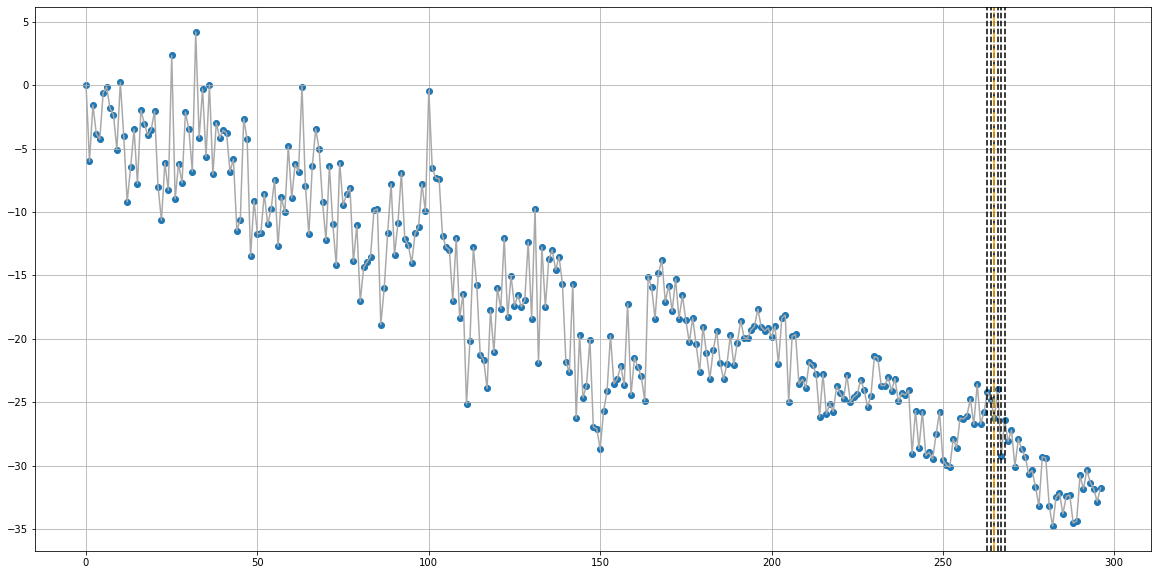

In [221]:
ts = 46

plt.figure(figsize=(20,10))
plt.plot(X_val[ts], color='darkgrey')
plt.scatter(range(297), X_val[ts])
# for i, val in enumerate(pred[ts]):
#     if val == 1:
#         plt.gca().axvline(i, linestyle='--', color='black')
for i in answers[ts]:
    plt.gca().axvline(i, linestyle='--', color='black')
for j in gt[ts]:
    plt.gca().axvline(j, linestyle='-.', color='orange')
plt.grid()

In [36]:
thresh_list = [0.0001, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5]
thresh_recalls = []
thresh_precisions = []
thresh_recalls_sup = []
thresh_precisions_sup = []

for thresh in thresh_list:

    pred_list = np.where(pred > thresh)[0]

    answers = [list(np.where(item > thresh)[0]) for item in pred]
    gt = [list(np.where(gt_item > 0)[0]) for gt_item in y_val]
    answers_scores =  [[pred[k][i] for i in ans] for k, ans in enumerate(answers)]
    answers_sup = [seg_line_sup(ans, vals) for ans, vals in zip(answers, answers_scores)]

    recalls = []
    precisions = []
    TPall = []
    FPall = []
    FNall = []

    for l in range(pred.shape[0]):
        r, p, tp, fp, fn = checkPerformance(answers[l], gt[l], tolerance = 5)
        recalls.append(r)
        precisions.append(p)
        TPall.append(tp)
        FPall.append(fp)
        FNall.append(fn)
    
    thresh_recalls.append(sum(TPall)/(sum(TPall) + sum(FNall)))
    thresh_precisions.append(sum(TPall)/(sum(TPall) + sum(FPall)))

    recalls = []
    precisions = []
    TPall = []
    FPall = []
    FNall = []

    for l in range(pred.shape[0]):
        r, p, tp, fp, fn = checkPerformance(answers_sup[l], gt[l], tolerance = 5)
        recalls.append(r)
        precisions.append(p)
        TPall.append(tp)
        FPall.append(fp)
        FNall.append(fn)


    print("Scores with non-minimum suppression", f"thresh: {thresh}")
    print()
    rec = sum(TPall)/(sum(TPall) + sum(FNall))
    prec = sum(TPall)/(sum(TPall) + sum(FPall))
    print('recall:',rec)
    print('precision:',prec, '\n')
    print(f"F1-score: {(2* rec * prec)/(rec + prec)}")
    print('-------------------------------------')

    thresh_recalls_sup.append(rec)
    thresh_precisions_sup.append(prec)


Scores with non-minimum suppression thresh: 0.0001

recall: 0.8518145161290323
precision: 0.057687056253413437 

F1-score: 0.10805626598465475
-------------------------------------
Scores with non-minimum suppression thresh: 0.001

recall: 0.49899193548387094
precision: 0.1586707981621968 

F1-score: 0.24077827320632345
-------------------------------------
Scores with non-minimum suppression thresh: 0.005

recall: 0.2933467741935484
precision: 0.47163695299837927 

F1-score: 0.3617153511497824
-------------------------------------
Scores with non-minimum suppression thresh: 0.01

recall: 0.22681451612903225
precision: 0.6709741550695825 

F1-score: 0.33902561526870917
-------------------------------------
Scores with non-minimum suppression thresh: 0.02

recall: 0.17170698924731181
precision: 0.8502495840266223 

F1-score: 0.28571428571428564
-------------------------------------
Scores with non-minimum suppression thresh: 0.03

recall: 0.14045698924731181
precision: 0.916666666666666

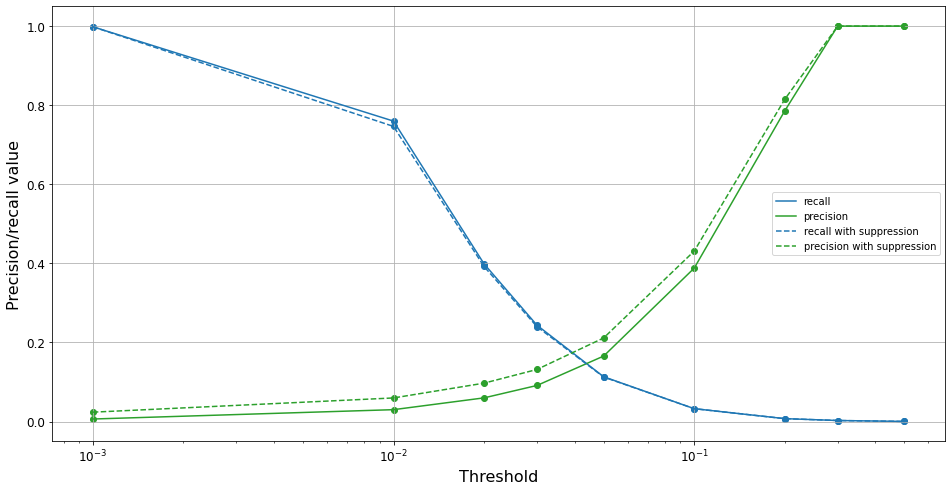

In [61]:
plt.figure(figsize=(16,8))
ax = plt.gca()
rec, = plt.plot(thresh_list, thresh_recalls, color='tab:blue', label="recall")
plt.scatter(thresh_list, thresh_recalls, color='tab:blue')
prec, = plt.plot(thresh_list, thresh_precisions, color='tab:green', label="precision")
plt.scatter(thresh_list, thresh_precisions, color='tab:green')
plt.xscale('log')

rec_sup, = plt.plot(thresh_list, thresh_recalls_sup, color='tab:blue', linestyle="--", label="recall with suppression")
plt.scatter(thresh_list, thresh_recalls_sup, color='tab:blue')
prec_sup, = plt.plot(thresh_list, thresh_precisions_sup, color='tab:green', linestyle="--", label="precision with suppression")
plt.scatter(thresh_list, thresh_precisions_sup, color='tab:green')

plt.xlabel("Threshold", fontsize = 16)
plt.ylabel("Precision/recall value", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[rec, prec, rec_sup, prec_sup])

plt.grid()
plt.show()


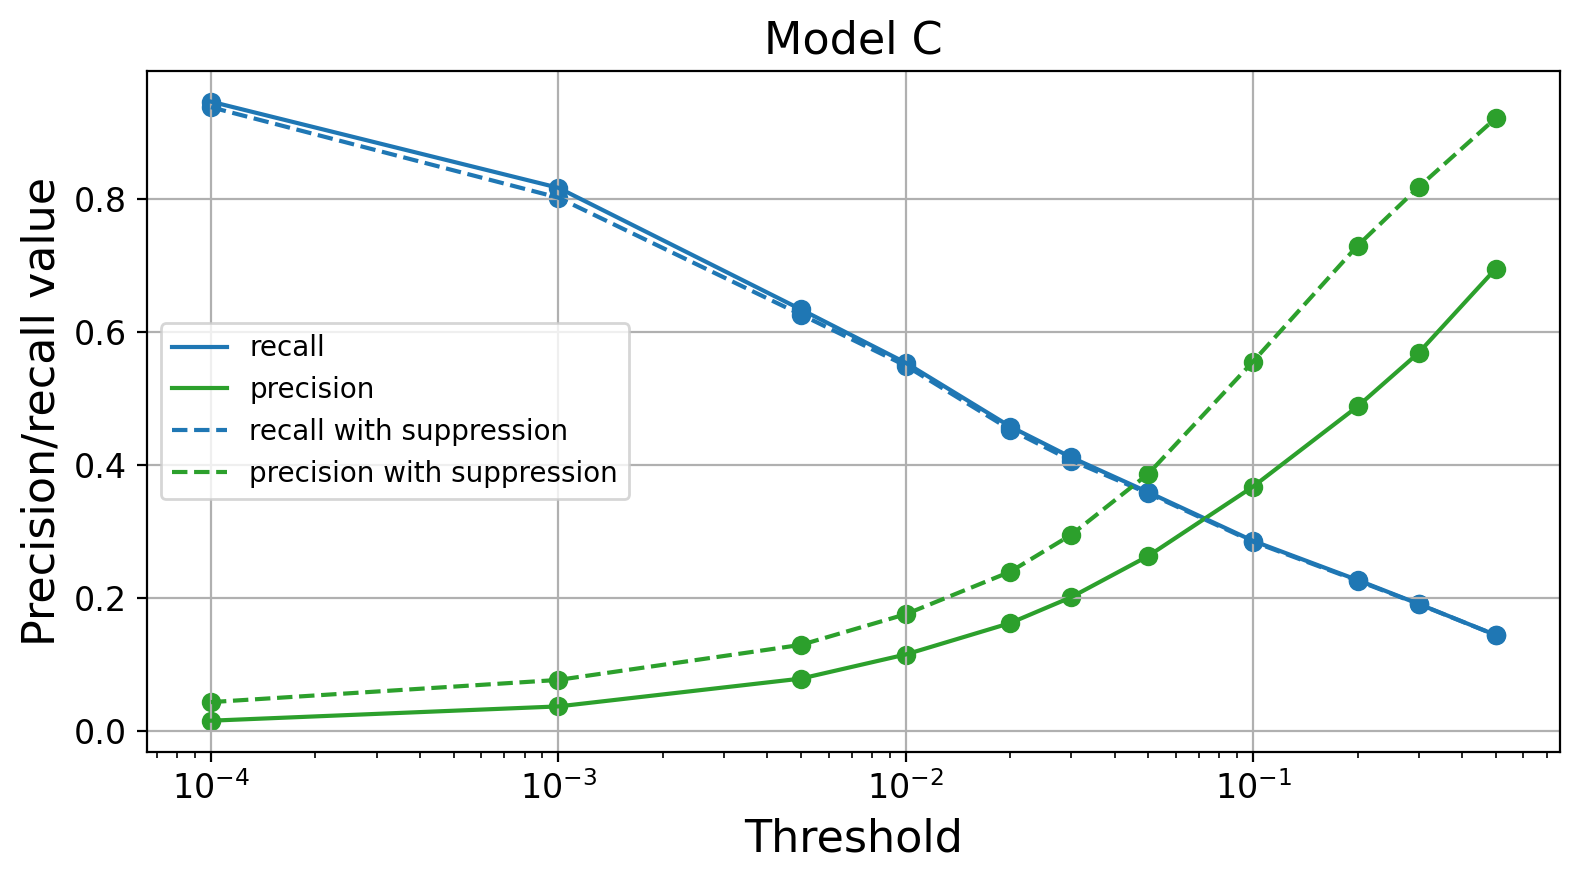

In [141]:
fig = plt.figure(figsize=(8,4.5), dpi=200)
ax = plt.gca()
rec, = plt.plot(thresh_list, thresh_recalls, color='tab:blue', label="recall")
plt.scatter(thresh_list, thresh_recalls, color='tab:blue')
prec, = plt.plot(thresh_list, thresh_precisions, color='tab:green', label="precision")
plt.scatter(thresh_list, thresh_precisions, color='tab:green')
plt.xscale('log')

rec_sup, = plt.plot(thresh_list, thresh_recalls_sup, color='tab:blue', linestyle="--", label="recall with suppression")
plt.scatter(thresh_list, thresh_recalls_sup, color='tab:blue')
prec_sup, = plt.plot(thresh_list, thresh_precisions_sup, color='tab:green', linestyle="--", label="precision with suppression")
plt.scatter(thresh_list, thresh_precisions_sup, color='tab:green')

plt.xlabel("Threshold", fontsize = 16)
plt.ylabel("Precision/recall value", fontsize = 16)
# plt.title("Model C", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[rec, prec, rec_sup, prec_sup])

plt.grid()

fig.tight_layout()
# fig.savefig('scores_model_D.jpg', bbox_inches="tight")
# fig.savefig('scores_model_C_w_title_big.jpg', bbox_inches="tight")

plt.show()

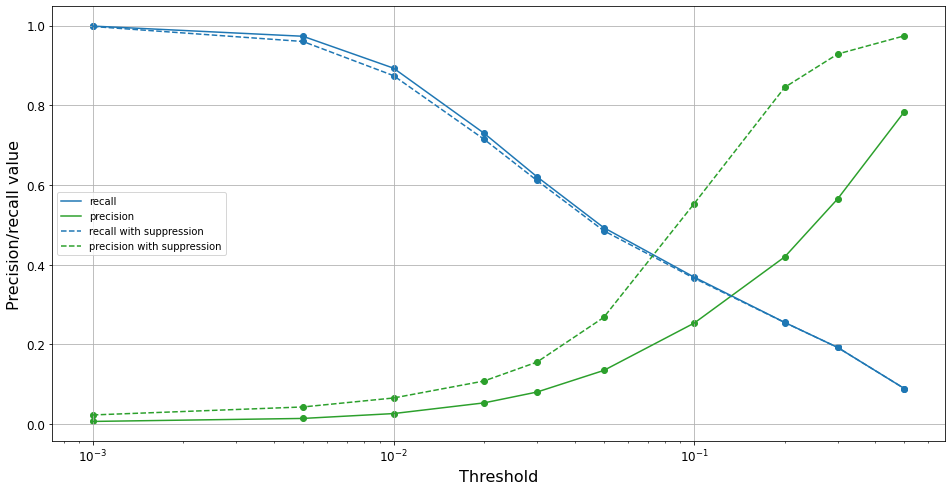

In [86]:
plt.figure(figsize=(16,8))
ax = plt.gca()
rec, = plt.plot(thresh_list, thresh_recalls, color='tab:blue', label="recall")
plt.scatter(thresh_list, thresh_recalls, color='tab:blue')
prec, = plt.plot(thresh_list, thresh_precisions, color='tab:green', label="precision")
plt.scatter(thresh_list, thresh_precisions, color='tab:green')
plt.xscale('log')

rec_sup, = plt.plot(thresh_list, thresh_recalls_sup, color='tab:blue', linestyle="--", label="recall with suppression")
plt.scatter(thresh_list, thresh_recalls_sup, color='tab:blue')
prec_sup, = plt.plot(thresh_list, thresh_precisions_sup, color='tab:green', linestyle="--", label="precision with suppression")
plt.scatter(thresh_list, thresh_precisions_sup, color='tab:green')

plt.xlabel("Threshold", fontsize = 16)
plt.ylabel("Precision/recall value", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[rec, prec, rec_sup, prec_sup])

plt.grid()
plt.show()

In [177]:
recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)

print("Overall scores")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')

recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers_sup[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)


print("Scores with non-minimum suppression")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')


print("Scores with non-minimum suppression", f"thresh: {thresh}")
print()
rec = sum(TPall)/(sum(TPall) + sum(FNall))
prec = sum(TPall)/(sum(TPall) + sum(FPall))
print('recall:',rec)
print('precision:',prec, '\n')
print(f"F1-score: {(2* rec * prec)/(rec + prec)}")
print('-------------------------------------')

Overall scores

recall: 0.3178603006189213
precision: 0.430912085216721 


TPall:  481
FPall:  864
FNall:  1018

recall: 0.3208805870580387
precision: 0.3576208178438662 

-------------------------------------
Scores with non-minimum suppression

recall: 0.3178603006189213
precision: 0.662766740250184 


TPall:  481
FPall:  344
FNall:  1018

recall: 0.3208805870580387
precision: 0.583030303030303 

-------------------------------------
Scores with non-minimum suppression thresh: 0.1

recall: 0.3208805870580387
precision: 0.583030303030303 

F1-score: 0.4139414802065405
-------------------------------------


### Trivial example

max pred value: 0.9999990463256836


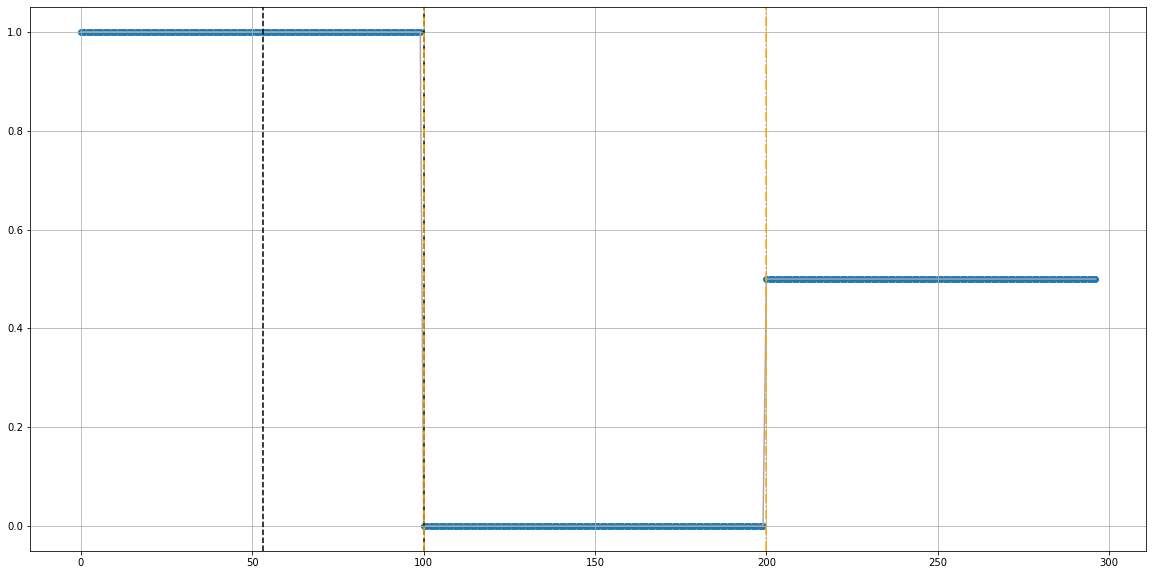

In [148]:
X_triv = np.zeros((297))
X_triv[0:100] = 1
X_triv[200:] = 0.5

# pred_triv = model_train.model.predict(np.expand_dims(X_triv.reshape(1, -1), axis=-1))
pred_triv = model_loaded.predict(np.expand_dims(X_triv.reshape(1, -1), axis=-1))

print(f"max pred value: {max(pred_triv[0])}")

plt.figure(figsize=(20,10))
plt.plot(X_triv, color='darkgrey')
plt.scatter(range(297), X_triv)
for i in np.where(pred_triv >= 0.1)[1]:
    plt.gca().axvline(i, linestyle='--', color='black')
for j in [100, 200]:
    plt.gca().axvline(j, linestyle='-.', color='orange')
plt.grid()

In [154]:
# model_loaded = keras.models.load_model("raw_cnn_model_24_best")
# pred = model_loaded.predict(np.expand_dims(X_val_scaled, axis=-1))

In [183]:
model_loaded.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 238, 64)           3904      
_________________________________________________________________
batch_normalization_10 (Batc (None, 238, 64)           256       
_________________________________________________________________
activation_20 (Activation)   (None, 238, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 194, 128)          368768    
_________________________________________________________________
batch_normalization_11 (Batc (None, 194, 128)          512       
_________________________________________________________________
activation_21 (Activation)   (None, 194, 128)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 97, 128)          

### Real data

In [15]:
with open("raw_real_input_data_ans_seg.pkl", "rb") as file:
    raw_real_input = pickle.load(file)
    
data_real = raw_real_input["data"]
ans_seg_real = raw_real_input["ans_seg"]

X_real = data_real
scaler_real = MinMaxScaler()
X_real_scaled = scaler_real.fit_transform(X_real.T).T

In [16]:
# pred = model_train.model.predict(np.expand_dims(X_real_scaled, axis=-1))
pred = model_loaded.predict(np.expand_dims(X_real_scaled, axis=-1))

thresh = 0.1

pred_list = np.where(pred > thresh)[0]
print(len(set(pred_list)))
print(pred_list)

answers = [list(np.where(item > thresh)[0]) for item in pred]
gt = [list(np.where(gt_item > 0)[0]) for gt_item in ans_seg_real]
answers_scores =  [[pred[k][i] for i in ans] for k, ans in enumerate(answers)]
answers_sup = [seg_line_sup(ans, vals) for ans, vals in zip(answers, answers_scores)]

recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)

print("Overall scores")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')

recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers_sup[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)


print("Scores with non-minimum suppression")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')

print("Scores with non-minimum suppression", f"thresh: {thresh}")
print()
rec = sum(TPall)/(sum(TPall) + sum(FNall))
prec = sum(TPall)/(sum(TPall) + sum(FPall))
print('recall:',rec)
print('precision:',prec, '\n')
print(f"F1-score: {(2* rec * prec)/(rec + prec)}")
print('-------------------------------------')

52
[ 0  0  1  1  1  3  3  4  4  5  5  6  6  6  7  7  7  7  7  9  9 11 11 12
 12 12 13 14 15 15 15 17 19 20 20 22 23 23 23 23 23 24 25 25 28 28 28 29
 29 29 29 29 30 30 30 31 31 34 34 34 34 35 35 36 36 36 36 36 37 37 37 41
 41 42 42 42 42 42 45 45 45 45 46 46 46 47 47 48 48 48 48 48 50 51 51 51
 51 51 52 52 53 53 53 54 54 54 57 57 57 58 58 58 58 58 58 58 58 58 58 59
 59 59 61 62 62 62 62 62 63 67 67 67 67 67 68 68 70 70 70 70 71 71 71 71
 73 73 73 73 73 73 76 76 76 79]
Overall scores

recall: 0.3230452674897119
precision: 0.2846153846153846 


TPall:  38
FPall:  116
FNall:  100

recall: 0.2753623188405797
precision: 0.24675324675324675 

-------------------------------------
Scores with non-minimum suppression

recall: 0.31069958847736623
precision: 0.3628205128205128 


TPall:  37
FPall:  75
FNall:  101

recall: 0.26811594202898553
precision: 0.33035714285714285 

-------------------------------------
Scores with non-minimum suppression thresh: 0.1

recall: 0.26811594202898553
precisio

In [507]:
r = iter(range(46, 80))

In [504]:
np.argmax(pred[67])

175

In [552]:
answers_sup_comp = []
for i in answers_sup:
    tmp = []
    for j in i:
        tmp.append(indices_reverse[j])
    answers_sup_comp.append(tmp)

In [553]:
recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers_sup_comp[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)


print("Scores with non-minimum suppression")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')

print("Scores with non-minimum suppression", f"thresh: {thresh}")
print()
rec = sum(TPall)/(sum(TPall) + sum(FNall))
prec = sum(TPall)/(sum(TPall) + sum(FPall))
print('recall:',rec)
print('precision:',prec, '\n')
print(f"F1-score: {(2* rec * prec)/(rec + prec)}")
print('-------------------------------------')

Scores with non-minimum suppression

recall: 0.3230452674897119
precision: 0.3820512820512821 


TPall:  38
FPall:  74
FNall:  100

recall: 0.2753623188405797
precision: 0.3392857142857143 

-------------------------------------
Scores with non-minimum suppression thresh: 0.1

recall: 0.2753623188405797
precision: 0.3392857142857143 

F1-score: 0.304
-------------------------------------


In [18]:
real_range = sorted(list(set(indices_reverse)))

In [556]:
X_real[23][real_range]

array([ 0. ,  0.4, -0.3, -0.6, -3.2, -1.3, -2.3, -2.7, -2.9,  0. , -4.9,
       -2.7, -1.6,  0.9, -5.9,  0.4, -1. , -0.6, -2.1, -3.5, -0.7, -1.5,
       -1.6, -2.3, -0.9, -1.2, -1. , -2.2, -2. ,  4.1,  3.8,  5. ,  5.2,
        4.7,  4.7,  3.7,  4.6,  2.7,  1.2, -0.8,  4. ,  4. ,  2.9,  3.3,
        1.7, -3.8,  2.7,  2.6,  1.6,  2. ,  2.2,  2.9,  4.3,  2.2,  1.1,
        4.8,  2.2,  4.4,  3.3,  2.2,  1.1, -0.4,  2.8, -1.4,  2.9, -0.5,
        4.3,  2.1,  2. ,  1.1,  2.1,  3.5,  2.4,  2.6,  3.3,  1.6,  2.4,
        3. ,  1. ,  0.3,  1.6,  1.2,  2. ,  1.1, -0.7, -0.4, -0.4,  0.2,
        1. ,  1.1,  1.1,  0.6,  1.6,  0.7,  1.8,  1.2,  1.1,  2.1,  1.4,
       -0.4,  0. ,  1. , -0.9, -0.7,  0.9,  0.3,  0.3,  0.1, -1.1,  0.1,
        0.7,  0.1, -0.6, -0.6,  0. , -0.4,  0.7,  0.5, -2.9, -0.3, -0.9,
       -1.2, -2.1, -2.4,  0.3,  1. , -3.4,  0.1, -0.3, -1.8, -0.3,  2.9,
       -0.8,  0.6, -0.5,  0. ,  3.6,  4.5,  4.2,  3.2,  3.5,  4.2,  2. ,
        2.9,  4. ,  2. ,  2.5,  4.5,  2.9,  3.9,  1

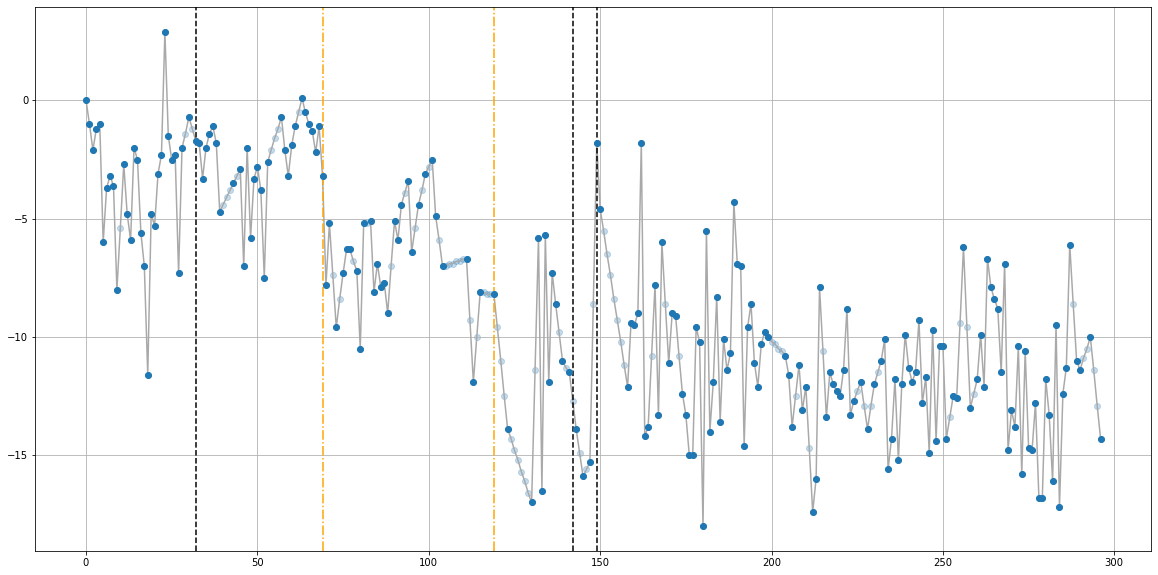

In [583]:
ts = 70

plt.figure(figsize=(20,10))
plt.plot(X_real[ts], color='darkgrey')
plt.scatter(range(297), X_real[ts], alpha=0.25, color="tab:blue")
plt.scatter(real_range, X_real[ts][real_range], zorder=4,  color="tab:blue")
for i in answers_sup[ts]:
    plt.gca().axvline(i, linestyle='--', color='black')
for j in gt[ts]:
    plt.gca().axvline(j, linestyle='-.', color='orange')
plt.grid()

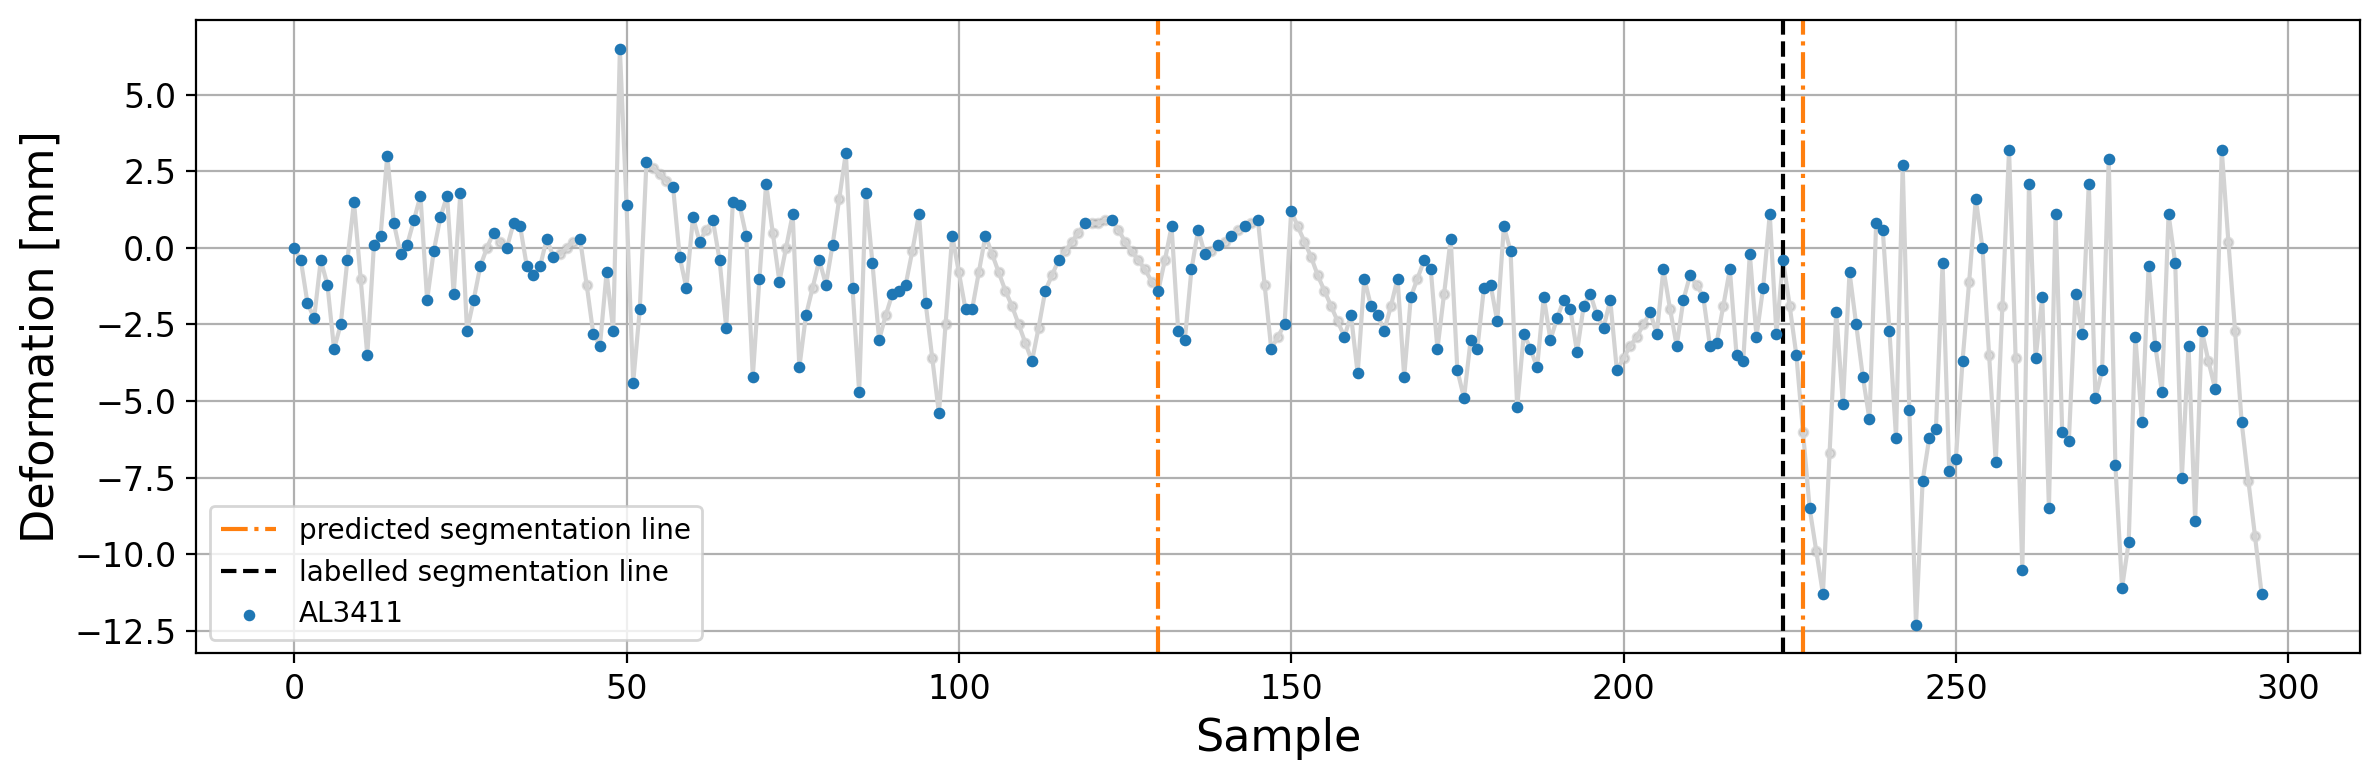

In [28]:
ts = 31

fig = plt.figure(figsize=(12,4), dpi=200)
ax = plt.gca()
plt.plot(X_real[ts], color='lightgrey')
# plt.scatter(range(297), X_real[ts], s=10, zorder=4)
plt.scatter(range(297), X_real[ts], s=10, alpha=0.25, color="tab:grey")
sc = plt.scatter(real_range, X_real[ts][real_range], s=10, zorder=4,  color="tab:blue", label="AL3411")
for i in answers_sup[ts]:
    bv = plt.gca().axvline(i, linestyle='-.', color='tab:orange', label="predicted segmentation line")
for j in gt[ts]:
    ov = plt.gca().axvline(j, linestyle='--', color='black', label="labelled segmentation line")

plt.xlabel("Sample", fontsize = 16)
plt.ylabel("Deformation [mm]", fontsize = 16)
# plt.title("Model C", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[bv, ov, sc])

plt.grid()

fig.tight_layout()
# fig.savefig(f'final_cnn_model_AL_{ts}_corrected_colors.jpg', bbox_inches="tight")

plt.show()